# Прогнозирование производственных таблиц с помощью регрессионных моделей

## 01. Подключение необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : '#D9D9D9'}
sns.set(rc={'figure.figsize': (9, 6)}, font_scale=1.3)

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [3]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## 02. Загрузка и обзор таблиц

In [4]:
train_data = pd.read_csv("data/train_data_200k.csv", index_col=0)
test_data = pd.read_csv("data/test_data_100k.csv", index_col=0)

In [5]:
train_data.head()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30402,...,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,25.30464,...,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30486,...,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,25.30544,...,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30540,...,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN


Для удобства работы создадим списки названий тегов и целевых переменных:

In [6]:
tags_names = np.array(train_data.columns[:-4])
targets_names = np.array(train_data.columns[-4:])
print(f"Теги: \n {tags_names}", 
      f"Целевые переменные: \n {targets_names}", 
      sep="\n\n")

Теги: 
 ['tag1' 'tag2' 'tag3' 'tag4' 'tag5' 'tag6' 'tag7' 'tag8' 'tag9' 'tag10'
 'tag11' 'tag12' 'tag13' 'tag14' 'tag15' 'tag16' 'tag17' 'tag18' 'tag19'
 'tag20' 'tag21' 'tag22' 'tag23' 'tag24' 'tag25' 'tag26' 'tag27' 'tag28'
 'tag29' 'tag30' 'tag31' 'tag32' 'tag33' 'tag34' 'tag35' 'tag36' 'tag37'
 'tag38' 'tag39' 'tag40' 'tag41' 'tag42' 'tag43' 'tag44' 'tag45' 'tag46'
 'tag47' 'tag48' 'tag49' 'tag50' 'tag51' 'tag52' 'tag53' 'tag54' 'tag55'
 'tag56' 'tag57' 'tag58' 'tag59' 'tag60' 'tag61' 'tag62' 'tag63' 'tag64'
 'tag65' 'tag66' 'tag67' 'tag68' 'tag69' 'tag70' 'tag71' 'tag72' 'tag73'
 'tag74' 'tag75' 'tag76' 'tag77' 'tag78' 'tag79']

Целевые переменные: 
 ['target1' 'target2' 'target3' 'target4']


### Пропущенные значения

Посмотрим на количество пропущенных значений в признаках.

Рассмотрим тэги:

In [7]:
np.array(train_data[tags_names].isnull().sum())

array([    66,  90630,  90544, 199915, 190264, 199627, 111878, 183223,
       199593,    163,    133,    125,    125,    125,    125,    125,
          125,    125,  99832,    133,    133,    133,    133,    133,
          133,    133,    133,    133,    133,    133,    133,    133,
          133,    133,    133, 160780, 161952,  41692,  47030, 184422,
       198593,    137,    133,  88275,  86200, 101590,    133,  67645,
          134, 121880, 185278,  98208, 115811, 140557,    133,    163,
          133,    163,    881,    125, 164190, 163274,    125,    133,
          133,    133,    133,    133, 162348,    133,    133,    133,
       164913,    133,    133,    133, 151197, 151327, 151442],
      dtype=int64)

In [8]:
train_data[tags_names].isnull().sum().sort_values(ascending=False).head(20)

tag4     199915
tag6     199627
tag9     199593
tag41    198593
tag5     190264
tag51    185278
tag40    184422
tag8     183223
tag73    164913
tag61    164190
tag62    163274
tag69    162348
tag37    161952
tag36    160780
tag79    151442
tag78    151327
tag77    151197
tag54    140557
tag50    121880
tag53    115811
dtype: int64

In [9]:
train_data[tags_names].isnull().sum().sort_values(ascending=True).head(10)

tag1      66
tag63    125
tag18    125
tag17    125
tag16    125
tag15    125
tag13    125
tag12    125
tag14    125
tag60    125
dtype: int64

Во всех признаках присутствуют пропущенные значения.

В топ-5 признаков по пропущенным значениям отсутствуют более 99% значений.

Рассмотрим целевые переменные:

In [10]:
train_data[targets_names].isnull().sum().sort_values(ascending=True)

target1    9
target2    9
target3    9
target4    9
dtype: int64

По сравнению с тегами, целевые переменные имеют незначительное количество пропущенных значений

### Дубликаты

In [11]:
train_data.duplicated().sum()

0

Дубликаты отсутствуют

### Описательные таблицы

In [12]:
train_data[targets_names].describe()

,target1,target2,target3,target4
count,199991.000000,199991.000000,199991.000000,199991.000000
mean,0.001156,0.049836,0.942428,0.006580
std,0.000085,0.003685,0.003936,0.001442
min,0.000826,0.035611,0.912861,0.002595
25%,0.001101,0.047461,0.940184,0.005565
50%,0.001155,0.049773,0.942605,0.006435
75%,0.001206,0.051962,0.945057,0.007307
max,0.001865,0.080406,0.956497,0.014346


## 03. Предобработка данных

Посмотрим на распределние целевых переменных в таблице train_data.

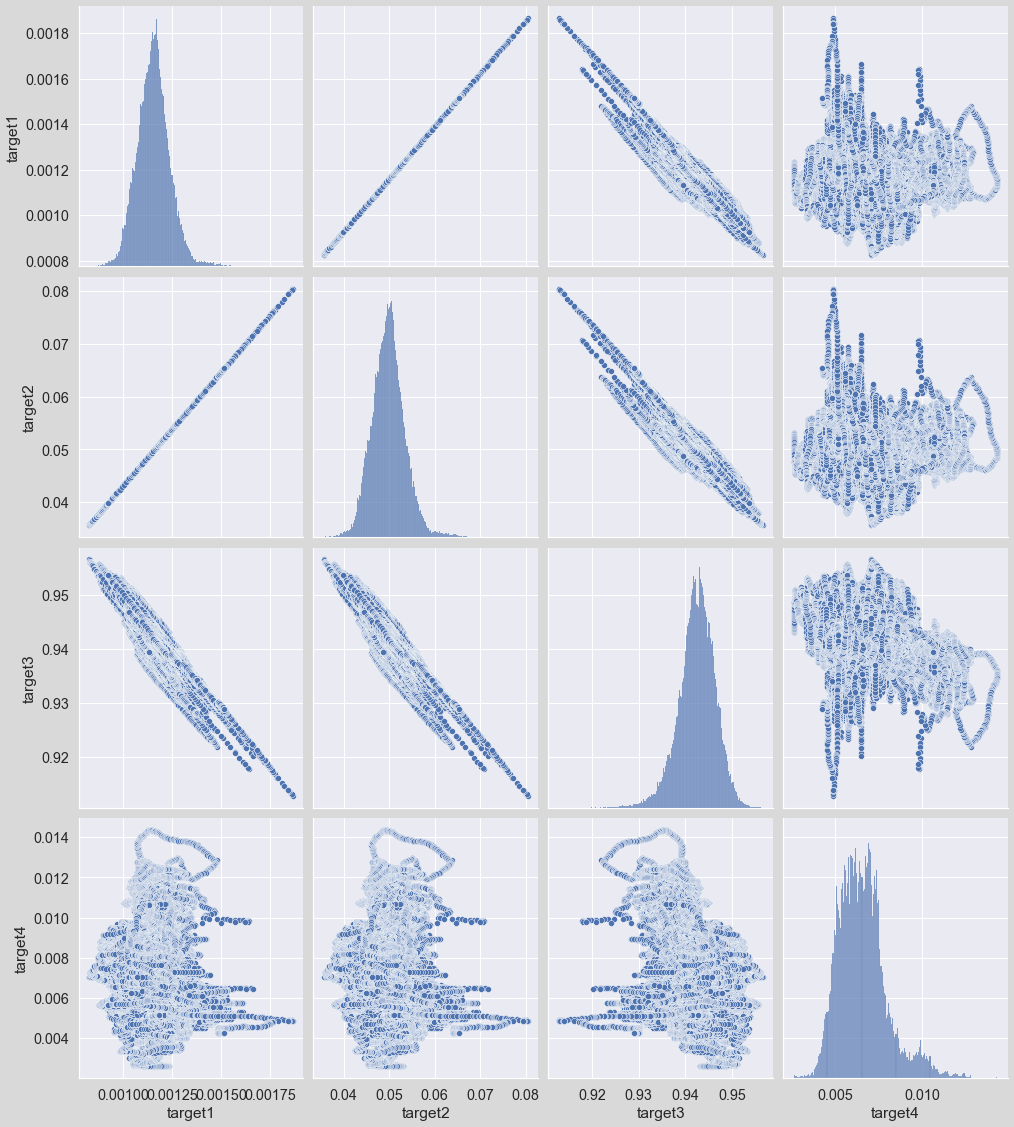

In [13]:
sns.pairplot(train_data, height=4, aspect=.9, vars=targets_names)

Разделим таблицу train_data на датафреймы с тегами и целевыми переменными соответственно.

Заменим множество пропущенных значений на медианы, так как регрессионные модели не обрабатывают такие значения.

In [14]:
train_data_target = train_data[targets_names].fillna(train_data[targets_names].median())
train_data_tags = train_data.drop(train_data_target, axis=1).fillna(train_data.median())

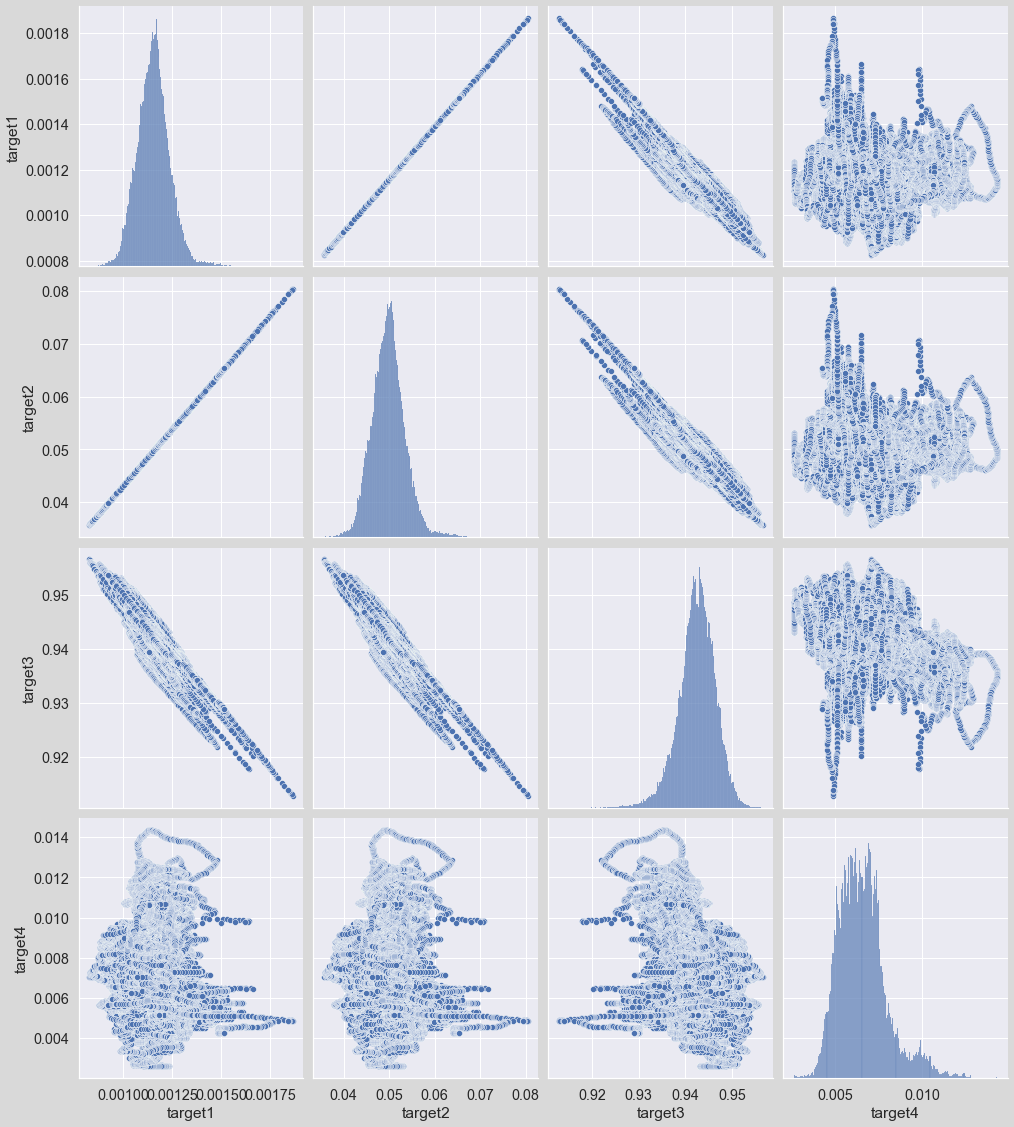

In [15]:
sns.pairplot(train_data_target, height=4, aspect=.9, vars=targets_names)

Разделим таблицу train_data на обучающую и тестовую выборки.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_data_tags, train_data_target, test_size=0.2)

In [17]:
print("X_train:", X_train.shape, 
      "X_test:", X_test.shape,
      "y_train:", y_train.shape,
      "y_test:", y_test.shape,
      sep="\n")

X_train:
(160000, 79)
X_test:
(40000, 79)
y_train:
(160000, 4)
y_test:
(40000, 4)


## 04. Линейные модели

Для прогнозирования целевых переменных попробуем применить линейные модели: модель линейной регрессии, а так же модели с L2, L1 регуляризацией (Ridge, Lasso).

In [54]:
linear_models = {"linear_regression" : LinearRegression(),
                 "ridge" : Ridge(alpha=0),
                 "lasso" : Lasso()}

In [55]:
pd.options.display.float_format = '{:.10f}'.format
metrics_table = pd.DataFrame(columns=["mae", "mse", "rmse", "r2"], index=linear_models.keys())

In [56]:
for model in linear_models.keys():
    fit = linear_models[model].fit(X_train, y_train)
    y_prediction = fit.predict(X_test)
    metrics_table.loc[model, :] = [metrics.mean_absolute_error(y_test, y_prediction),
                                   metrics.mean_squared_error(y_test, y_prediction),
                                   np.sqrt(metrics.mean_squared_error(y_test, y_prediction)),
                                   metrics.r2_score(y_test, y_prediction)]

Оценим качество модели по метрикам:
- MAE - средняя абсолютная ошибка
- MSE - средняя квадратичная ошибка
- RMSE - корень из средней квадратичной ошибки
- $R^2$ - коэффициэнт детерминации

In [57]:
metrics_table.sort_values(["mse", "r2"], ascending=True)

,mae,mse,rmse,r2
linear_regression,0.0005520975,0.0000010301,0.0010149385,0.8590804103
ridge,0.0005519554,0.0000010303,0.0010150170,0.8590615905
lasso,0.0017493498,0.0000077232,0.0027790597,-0.0000706162


Модель линейной регрессии без регуляризации по метрикам MSE и $R^2$ отработала более качественно чем модели с регуляризацией.

Попробуем отобрать наиболее значимые признаки с помощью простой модели случайного леса.

In [49]:
model_random_forest = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_split=5, random_state=42)
model_random_forest.fit(X_train, y_train)
y_prediction_random_forest = model_random_forest.predict(X_test)
print("MSE:", metrics.mean_squared_error(y_test, y_prediction_random_forest))

MSE: 3.041723584778845e-06


Воспользуемся атриубутом feature_importances_

In [50]:
importance_features = pd.DataFrame(train_data_tags.columns, columns=["tags"])
importance_features["importance_score"] = model_random_forest.feature_importances_
top_features = importance_features.sort_values("importance_score", ascending=False).reset_index(drop=True)
top_features[top_features["importance_score"] != 0]

,tags,importance_score
0,tag49,0.3717891611
1,tag75,0.2702206049
2,tag59,0.1549815077
3,tag67,0.0812553289
4,tag42,0.0575468257
5,tag71,0.0153666152
6,tag43,0.0123193841
7,tag76,0.0051471377
8,tag30,0.0041190766
9,tag21,0.0034601296


In [56]:
top_features_names = np.array(top_features[top_features["importance_score"] != 0]["tags"])
print("Количество признаков:", len(top_features_names),
      "Названия признаков: ", top_features_names,
      sep="\n")

Количество признаков:
31
Названия признаков: 
['tag49' 'tag75' 'tag59' 'tag67' 'tag42' 'tag71' 'tag43' 'tag76' 'tag30'
 'tag21' 'tag58' 'tag3' 'tag72' 'tag64' 'tag1' 'tag26' 'tag31' 'tag12'
 'tag65' 'tag20' 'tag70' 'tag25' 'tag10' 'tag24' 'tag56' 'tag19' 'tag16'
 'tag2' 'tag22' 'tag34' 'tag74']


Простая модель случайного леса с 10 деревьями отобрала 31 признак.

Попробуем обучить наши линейные модели только на этих признаках.

Проверим изменились ли значения метрик.

In [57]:
new_linear_metrics_table = pd.DataFrame(columns=["mae", "mse", "rmse", "r2"], index=linear_models.keys())
X_train_top = X_train[top_features_names]
X_test_top = X_test[top_features_names]
for model in linear_models.keys():
    fit = linear_models[model].fit(X_train_top, y_train)
    y_prediction = fit.predict(X_test_top)
    new_linear_metrics_table.loc[model, :] = [metrics.mean_absolute_error(y_test, y_prediction),
                                              metrics.mean_squared_error(y_test, y_prediction),
                                              np.sqrt(metrics.mean_squared_error(y_test, y_prediction)),
                                              metrics.r2_score(y_test, y_prediction)]
new_linear_metrics_table.sort_values(["mse", "r2"], ascending=True)

,mae,mse,rmse,r2
ridge,0.0006490150,0.0000015630,0.0012501874,0.7953876450
linear_regression,0.0006490376,0.0000015630,0.0012501987,0.7953845716
lasso,0.0006723757,0.0000015808,0.0012572956,0.7574893588


Качество моделей снизилось.

Попробуем применить для линейных моделей кросс-валидацию с помощью метода cross_val_score, с разбиением на 5 блоков.

Будем оценивать качество моделей по метрике MSE.

In [46]:
scorer = metrics.make_scorer(metrics.mean_squared_error, 
                             greater_is_better=True)
mse_cv = pd.DataFrame(index=linear_models.keys(), columns=["mean_squared_error"])

for model in linear_models.keys():
    cv_linear_scoring = cross_val_score(linear_models[model], 
                                        train_data_tags, 
                                        train_data_target, 
                                        scoring=scorer,
                                        cv=5)
    mse_cv.loc[model, :] = cv_linear_scoring.mean()

In [47]:
mse_cv.sort_values("mean_squared_error")

,mean_squared_error
lasso,0.0000034931
ridge,0.0000043414
linear_regression,0.0000043587


Качество моделей с использованием кросс-валидации ниже чем на отложенной выборке.

## 05. Случайный лес

Попробуем применить модель случайного леса, для нашей задачи регрессии.

Изменим параметры предыдущей модели случайного леса, в словаре rf_params. 

In [83]:
rf_params = {"n_estimators"     : 100,
             "max_depth"        : 10,
             "min_samples_split": 10}

random_forest = RandomForestRegressor(**rf_params, random_state=42, n_jobs=-1)

In [84]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, n_jobs=-1,
                      random_state=42)

In [85]:
y_prediction_rf = random_forest.predict(X_test)
print(f"MSE: {metrics.mean_squared_error(y_test, y_prediction_rf)}",
      f"R2: {metrics.r2_score(y_test, y_prediction_rf)}",
      sep="\n")

MSE: 8.836311333588881e-07
R2: 0.8857559198226391


По метрике MSE, случайный лес выдает показатель на порядок лучше линейных моделей. $R^2$ также вырос по сравнению с линейными моделями, что говорит нам о лучшем качестве.

Посмотрим на наиболее значимые теги используя новую модель случайного леса.

In [107]:
new_importance_features = pd.DataFrame(train_data_tags.columns, columns=["tags"])
new_importance_features["importance_score"] = random_forest.feature_importances_
final_top_features = new_importance_features.sort_values("importance_score", ascending=False).reset_index(drop=True)
final_top_features[top_features["importance_score"] != 0]

,tags,importance_score
0,tag49,0.2704026833
1,tag75,0.2015853888
2,tag59,0.1460186922
3,tag42,0.0777642071
4,tag67,0.0718123811
5,tag58,0.0507015650
6,tag71,0.0270865284
7,tag43,0.0234425698
8,tag63,0.0079911805
9,tag60,0.0072553302


Выведем топ-10 значимых тегов в файл top_tags.csv

In [109]:
final_top_features.head(10).to_csv("top_tags.csv", index=False)

## 06. Прогноз

In [98]:
test_data.isnull().sum()

tag1        172
tag2     100000
tag3     100000
tag4      99922
tag5      85061
          ...  
tag75       172
tag76       172
tag77     74866
tag78     74938
tag79     10966
Length: 79, dtype: int64

В тестовой выборке присутствуют теги tag2, tag3 с полностью пропущенными значениями. Проведем их замену на нули. В остальных тегах заменим пропущенные значения на медиану.

In [111]:
test_data[["tag2", "tag3"]] = 0
test_data_not_null = test_data.fillna(test_data.median())
test_data_not_null.head()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
2017-01-03 21:21:00,12.5997200000,0.0000000000,0.0000000000,9.4568695000,42.0631100000,74.5269500000,45.2799300000,43.1364400000,73.0772100000,18.5259900000,...,37.6364400000,40.6441000000,53.4447000000,72.8045900000,36.5956700000,64.4752300000,45.0892000000,76.1776150000,93.3911650000,56.2279650000
2017-01-03 21:22:00,12.6585000000,0.0000000000,0.0000000000,9.4568695000,42.0631100000,74.5269500000,48.4349700000,42.9845500000,73.0772100000,18.5253000000,...,37.6920100000,40.6803000000,53.4395300000,72.8045900000,36.6071500000,64.4869700000,45.1812700000,76.1776150000,93.3911650000,56.2279650000
2017-01-03 21:23:00,12.6953800000,0.0000000000,0.0000000000,9.4568695000,42.0631100000,74.5269500000,48.4349700000,41.8740100000,73.0772100000,18.5250500000,...,37.7114700000,40.6928600000,53.4273300000,72.8045900000,36.6019400000,64.4803400000,45.0052900000,75.8416900000,93.3911650000,56.2279650000
2017-01-03 21:24:00,12.8472600000,0.0000000000,0.0000000000,9.4568695000,42.0631100000,74.5269500000,48.4349700000,41.7800600000,73.0772100000,18.5245000000,...,37.7042700000,40.6171600000,53.4409700000,72.8045900000,36.6187900000,64.5022000000,45.1098700000,76.1776150000,93.6209700000,56.2279650000
2017-01-03 21:25:00,12.9824600000,0.0000000000,0.0000000000,9.4568695000,42.0631100000,74.5269500000,48.4349700000,46.9628500000,73.0772100000,18.5261300000,...,37.6934300000,40.6450700000,53.5123700000,72.8045900000,36.5987500000,64.4830000000,45.1224600000,76.1776150000,93.3911650000,56.1464700000


Выведем предсказанные целевые переменные для тестовой выборки test_data в переменную predictions, а также найденные значения в файл predictions.csv.

In [140]:
predictions = random_forest.predict(test_data_not_null)
predictions

array([[0.00150814, 0.06500674, 0.92892017, 0.00456495],
       [0.00150764, 0.06498494, 0.9289471 , 0.00456031],
       [0.00150827, 0.065012  , 0.92891453, 0.0045652 ],
       ...,
       [0.00124793, 0.05378992, 0.93918373, 0.00577842],
       [0.00124636, 0.05372262, 0.93927061, 0.0057604 ],
       [0.00124609, 0.05371092, 0.93928211, 0.00576088]])

In [142]:
predictions_df = pd.DataFrame(index=test_data.index, columns=targets_names)
for i in range(0, len(targets_names)):
        predictions_df[f"target{i+1}"] = predictions[:, i]
predictions_df.head()

,target1,target2,target3,target4
2017-01-03 21:21:00,0.0015081433,0.0650067436,0.9289201655,0.0045649477
2017-01-03 21:22:00,0.0015076390,0.0649849435,0.9289471048,0.0045603128
2017-01-03 21:23:00,0.0015082654,0.0650119956,0.9289145347,0.0045652044
2017-01-03 21:24:00,0.0015079693,0.0649992279,0.9289291499,0.0045636529
2017-01-03 21:25:00,0.0015075392,0.0649806476,0.9289294877,0.0045823257


In [146]:
#sns.pairplot(predictions_df, height=4, aspect=.9, vars=targets_names)

In [143]:
predictions_df.to_csv("predictions.csv", index=True)

In [144]:
predictions_df.to_csv("predictions_without_index.csv", index=False)